# CityX Crime Watch: Operation Safe Streets

## Project Overview

This notebook presents a comprehensive solution to the 2025 ML Rihal Codestacker Challenge. The challenge focuses on helping the CityX Police Department analyze crime data to uncover patterns, predict crime types, and build an efficient system for rapid response.

### Problem Statement

The CityX Police Department has collected a comprehensive crime dataset containing:
- Timestamps of incidents
- Crime categories and descriptions
- Location information (districts, coordinates)
- Resolution details

Our mission is to:
1. Clean and analyze the data
2. Build models for crime classification
3. Create visualizations and interactive tools
4. Extract information from police reports

### Challenge Levels

This notebook addresses all levels of the challenge:
1. **Level 1**: Exploratory Data Analysis (EDA)
2. **Level 2**: Crime Classification & Severity Assignment
3. **Level 3**: Geo-Spatial Mapping & Basic Web UI
4. **Level 4**: Advanced Web UI & Report Extraction
5. **Bonus Task**: Deployment

Let's begin our journey into CityX's crime data!

## 1. Data Loading & Initial Inspection

First, let's import the necessary libraries and load our dataset.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import os
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
print("Loading crime dataset...")
data = pd.read_csv("Competition_Dataset.csv")
print(f"Dataset loaded with {data.shape[0]} rows and {data.shape[1]} columns.")

# Display the first few rows
data.head()

Loading crime dataset...
Dataset loaded with 680826 rows and 9 columns.


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Latitude (Y),Longitude (X)
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
# Check columns and data types
print("Column information:")
data.info()

# Check for missing values
print("\nMissing values per column:")
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
})
print(missing_df[missing_df['Missing Values'] > 0])

# Get basic statistics
print("\nBasic statistics:")
data.describe().T

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680826 entries, 0 to 680825
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Dates          680826 non-null  object 
 1   Category       680826 non-null  object 
 2   Descript       680826 non-null  object 
 3   DayOfWeek      680826 non-null  object 
 4   PdDistrict     680826 non-null  object 
 5   Resolution     680826 non-null  object 
 6   Address        680826 non-null  object 
 7   Latitude (Y)   680826 non-null  float64
 8   Longitude (X)  680826 non-null  float64
dtypes: float64(2), object(7)
memory usage: 46.7+ MB

Missing values per column:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Basic statistics:


,count,mean,std,min,25%,50%,75%,max
Latitude (Y),680826.0,-122.422852,0.030744,-122.513642,-122.433532,-122.416517,-122.406843,-120.5
Longitude (X),680826.0,37.771560,0.470065,37.707879,37.752837,37.775421,37.784464,90.0


Number of unique crime categories: 25


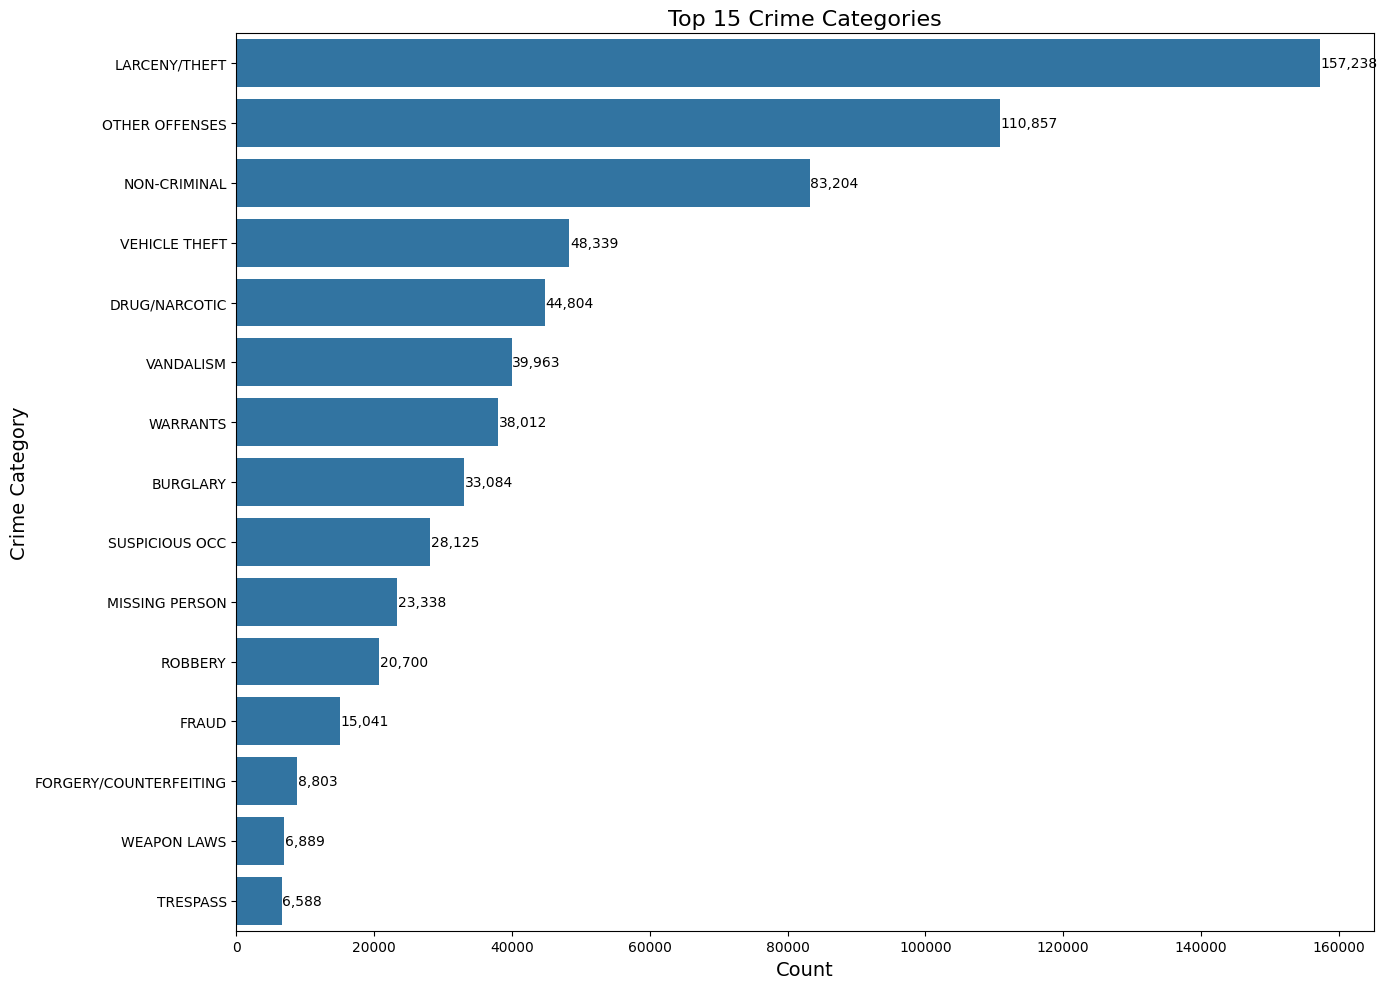

The top 5 categories represent 65.28% of all crimes


In [5]:
# Count of each crime category
category_counts = data['Category'].value_counts()
print(f"Number of unique crime categories: {len(category_counts)}")

# Plot category distribution
plt.figure(figsize=(14, 10))
ax = sns.barplot(x=category_counts.values[:15], y=category_counts.index[:15])
plt.title('Top 15 Crime Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Crime Category', fontsize=14)

# Add count labels to bars
for i, count in enumerate(category_counts.values[:15]):
    ax.text(count + 100, i, f"{count:,}", va='center')
    
plt.tight_layout()
plt.show()

# Calculate percentage
top_categories_percentage = (category_counts.values[:5].sum() / category_counts.values.sum()) * 100
print(f"The top 5 categories represent {top_categories_percentage:.2f}% of all crimes")

## 2. Exploratory Data Analysis (EDA)
Now let's dive deeper into patterns within our data to address Level 1 of the challenge.

### 2.1 Temporal Analysis

Let's examine how crimes vary by time of day, day of week, and month:

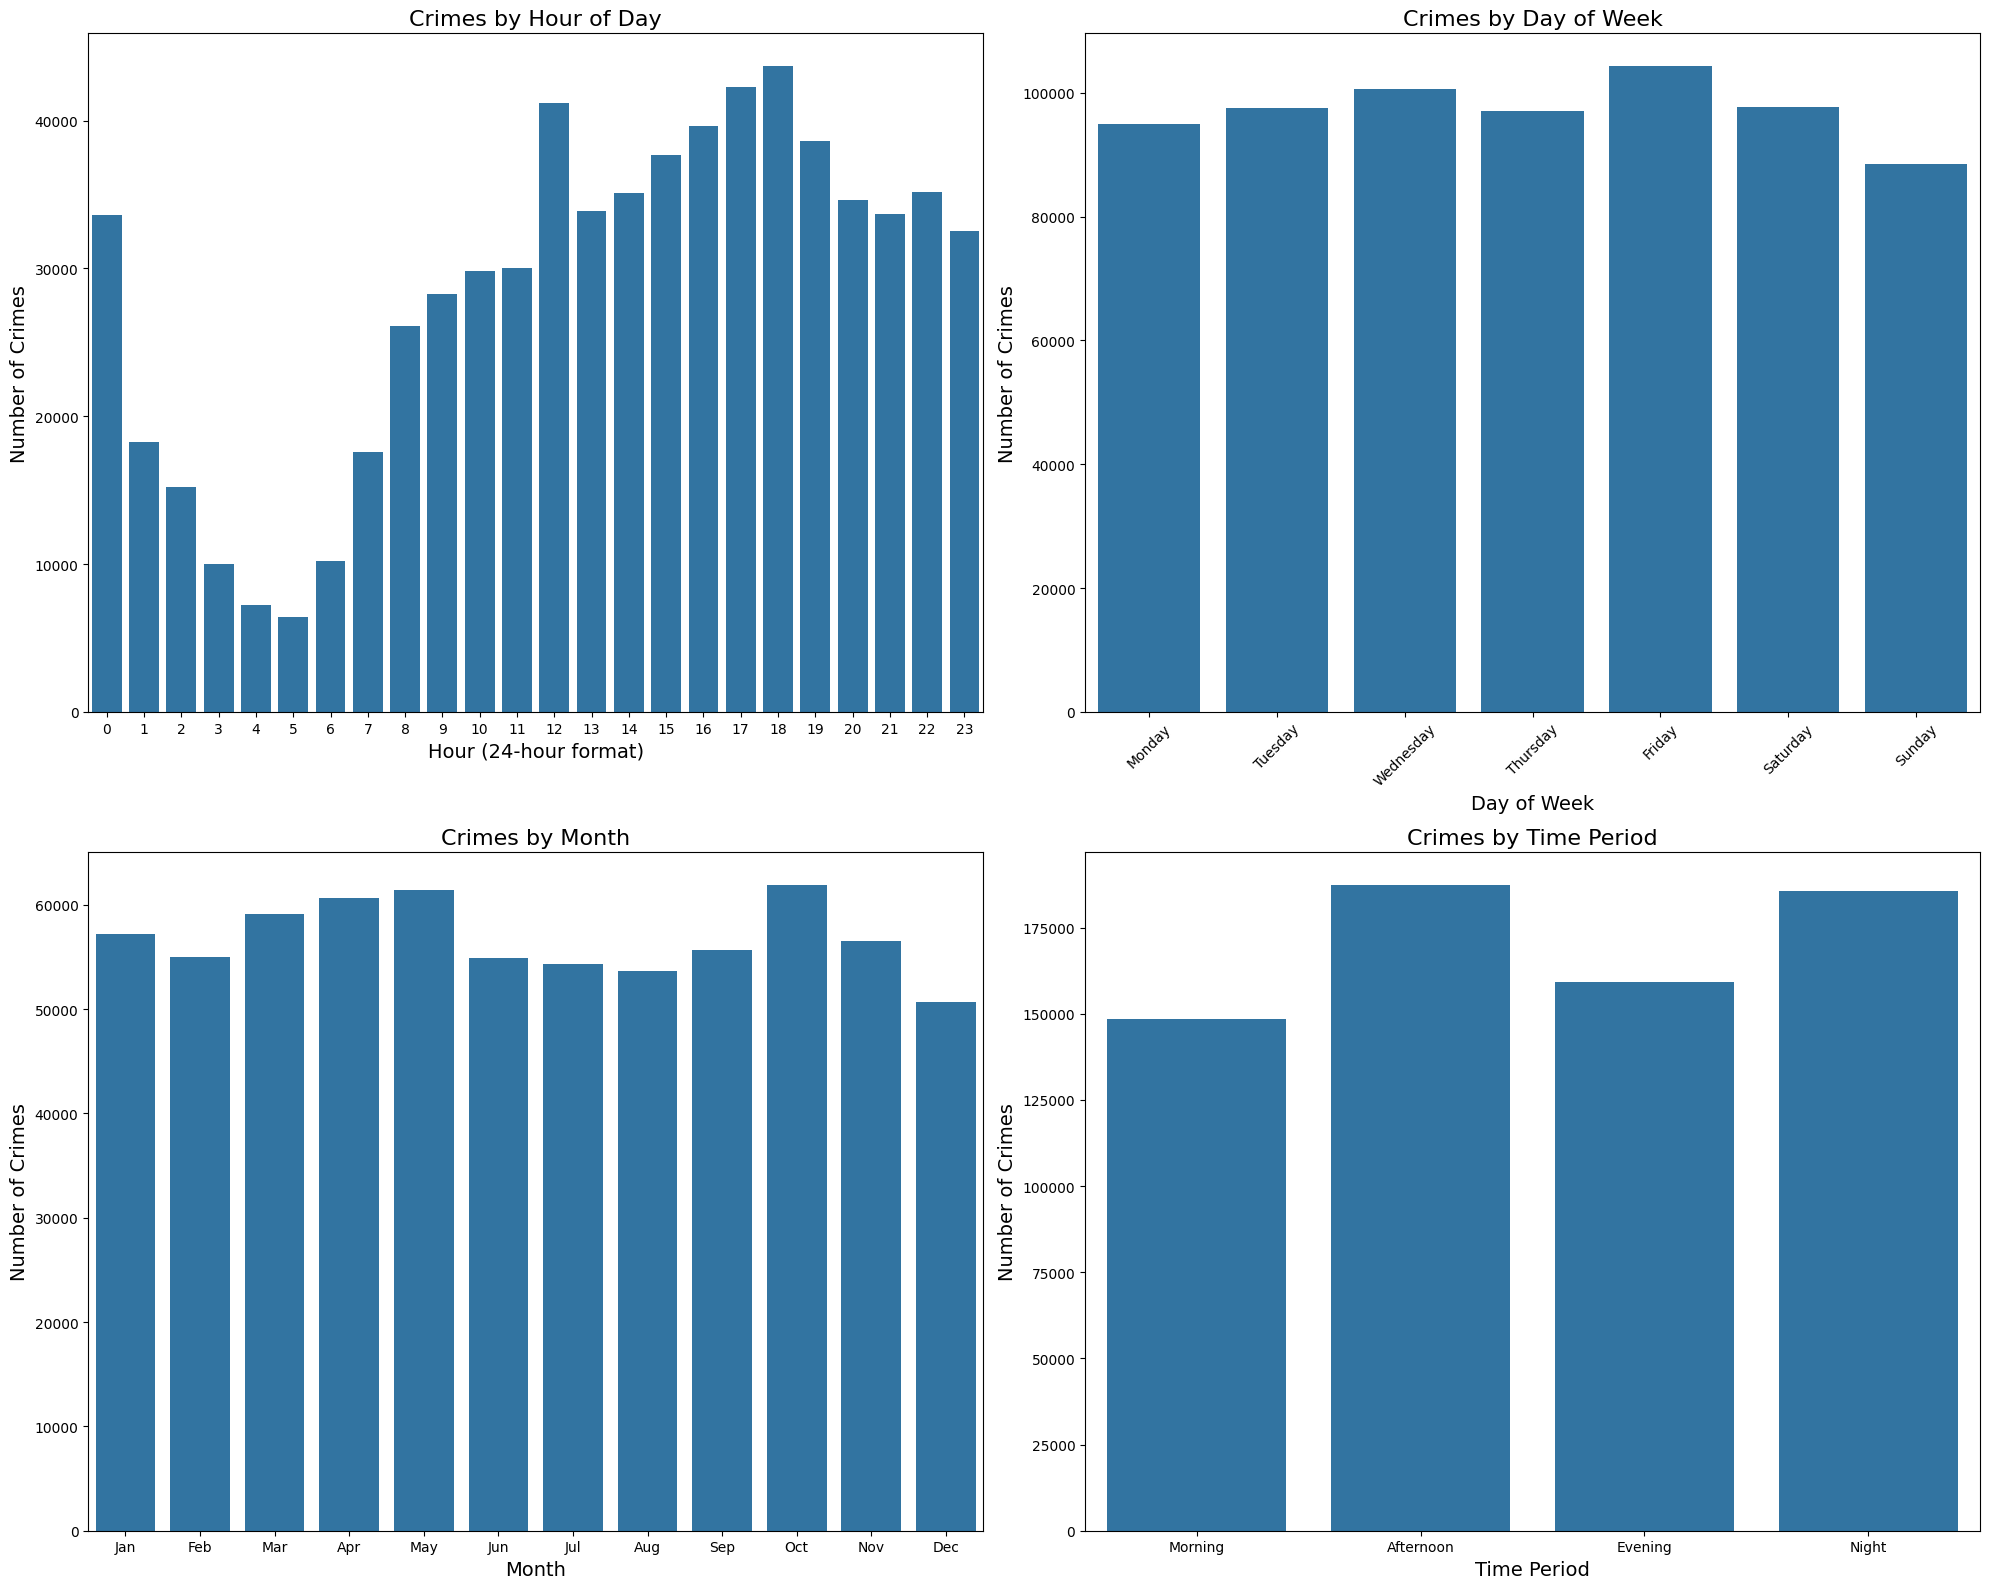

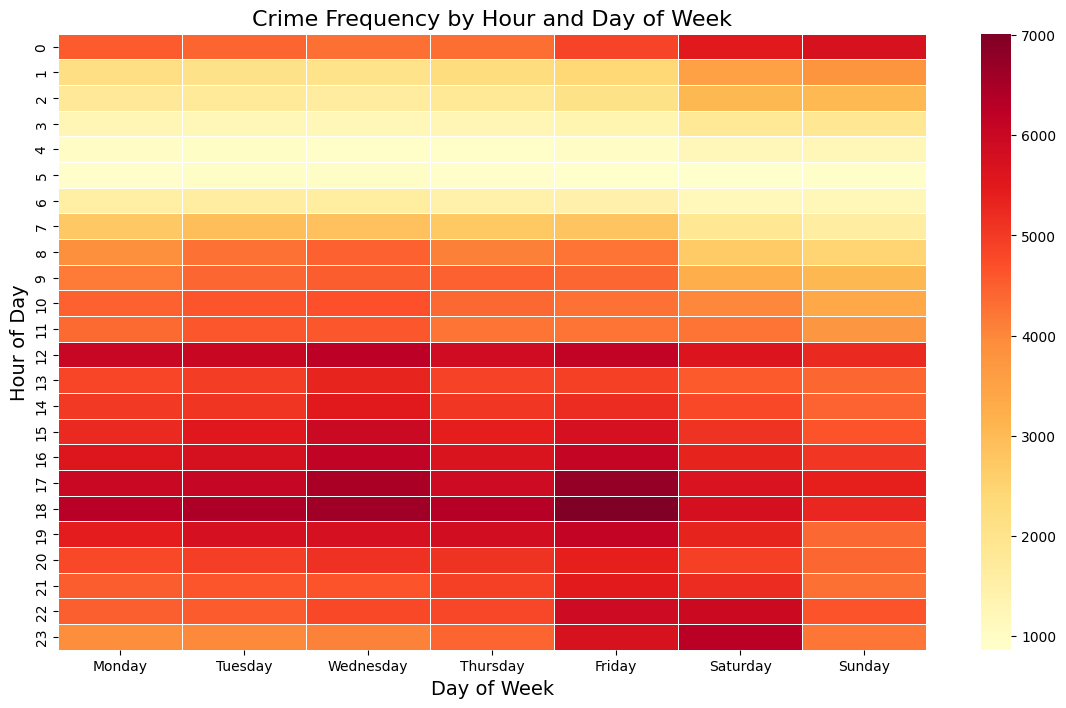

In [6]:
# Convert Dates to datetime
data['Dates'] = pd.to_datetime(data['Dates'])

# Extract time components
data['Hour'] = data['Dates'].dt.hour
data['Day'] = data['Dates'].dt.day
data['Month'] = data['Dates'].dt.month
data['Year'] = data['Dates'].dt.year
data['DayOfWeek_Num'] = data['Dates'].dt.weekday
data['WeekendFlag'] = data['DayOfWeek_Num'].apply(lambda x: 1 if x >= 5 else 0)

# Define time periods
def assign_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['TimePeriod'] = data['Hour'].apply(assign_time_period)

# Create a figure with multiple subplots for temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Crimes by hour of day
hourly_crimes = data.groupby('Hour').size()
sns.barplot(x=hourly_crimes.index, y=hourly_crimes.values, ax=axes[0, 0])
axes[0, 0].set_title('Crimes by Hour of Day', fontsize=16)
axes[0, 0].set_xlabel('Hour (24-hour format)', fontsize=14)
axes[0, 0].set_ylabel('Number of Crimes', fontsize=14)

# Plot 2: Crimes by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_crimes = data.groupby('DayOfWeek').size().reindex(day_order)
sns.barplot(x=day_crimes.index, y=day_crimes.values, ax=axes[0, 1])
axes[0, 1].set_title('Crimes by Day of Week', fontsize=16)
axes[0, 1].set_xlabel('Day of Week', fontsize=14)
axes[0, 1].set_ylabel('Number of Crimes', fontsize=14)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Crimes by month
monthly_crimes = data.groupby('Month').size()
sns.barplot(x=monthly_crimes.index, y=monthly_crimes.values, ax=axes[1, 0])
axes[1, 0].set_title('Crimes by Month', fontsize=16)
axes[1, 0].set_xlabel('Month', fontsize=14)
axes[1, 0].set_ylabel('Number of Crimes', fontsize=14)
axes[1, 0].set_xticks(range(12))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot 4: Crimes by time period
period_order = ['Morning', 'Afternoon', 'Evening', 'Night']
period_crimes = data.groupby('TimePeriod').size().reindex(period_order)
sns.barplot(x=period_crimes.index, y=period_crimes.values, ax=axes[1, 1])
axes[1, 1].set_title('Crimes by Time Period', fontsize=16)
axes[1, 1].set_xlabel('Time Period', fontsize=14)
axes[1, 1].set_ylabel('Number of Crimes', fontsize=14)

plt.tight_layout()
plt.show()

# Let's also look at the heatmap of crimes by hour and day of week
plt.figure(figsize=(14, 8))
hour_day_crimes = data.groupby(['Hour', 'DayOfWeek_Num']).size().unstack()
# Reorder the columns to have days in correct order
hour_day_crimes = hour_day_crimes[[0, 1, 2, 3, 4, 5, 6]]
hour_day_crimes.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the heatmap
sns.heatmap(hour_day_crimes, cmap='YlOrRd', annot=False, fmt='d', linewidths=.5)
plt.title('Crime Frequency by Hour and Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Hour of Day', fontsize=14)
plt.show()

### 2.2 Spatial Analysis
Now let's analyze how crimes are distributed across different districts:

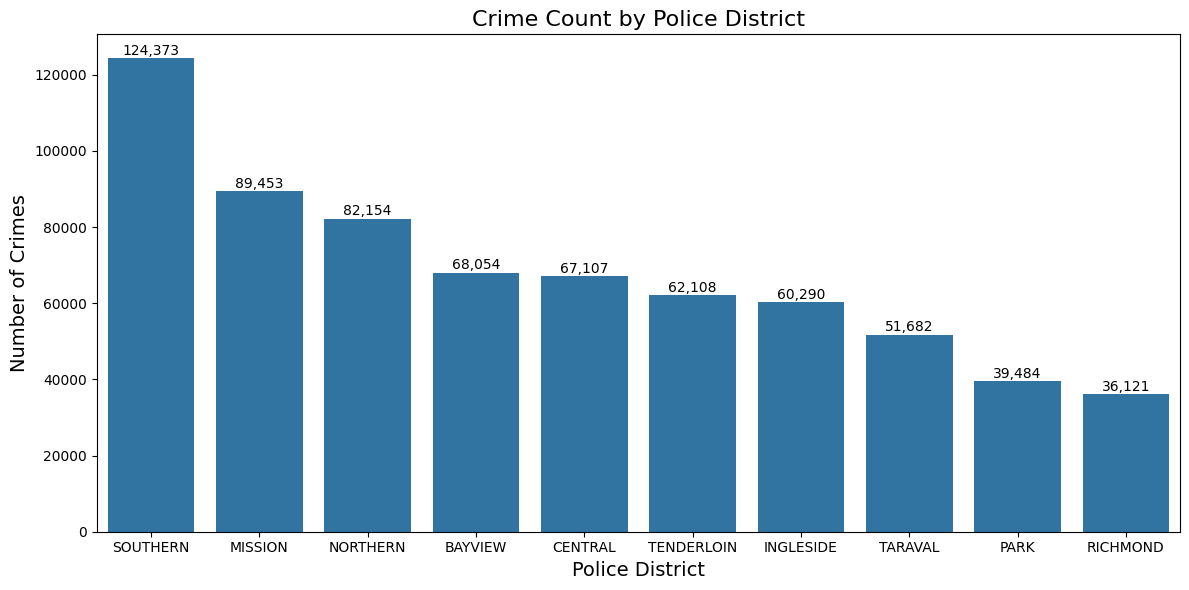

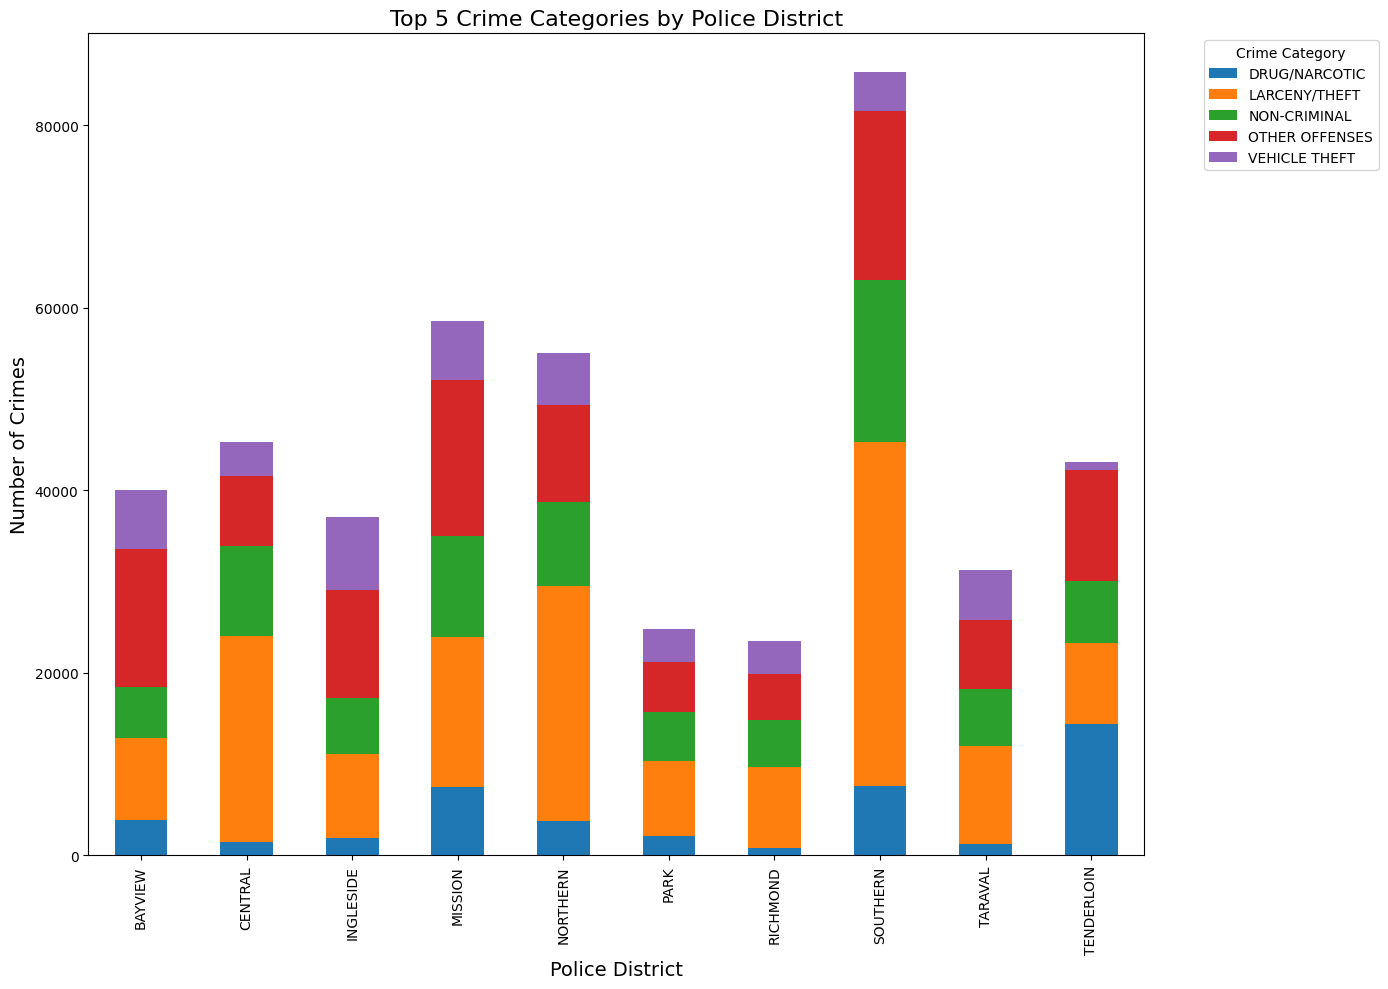

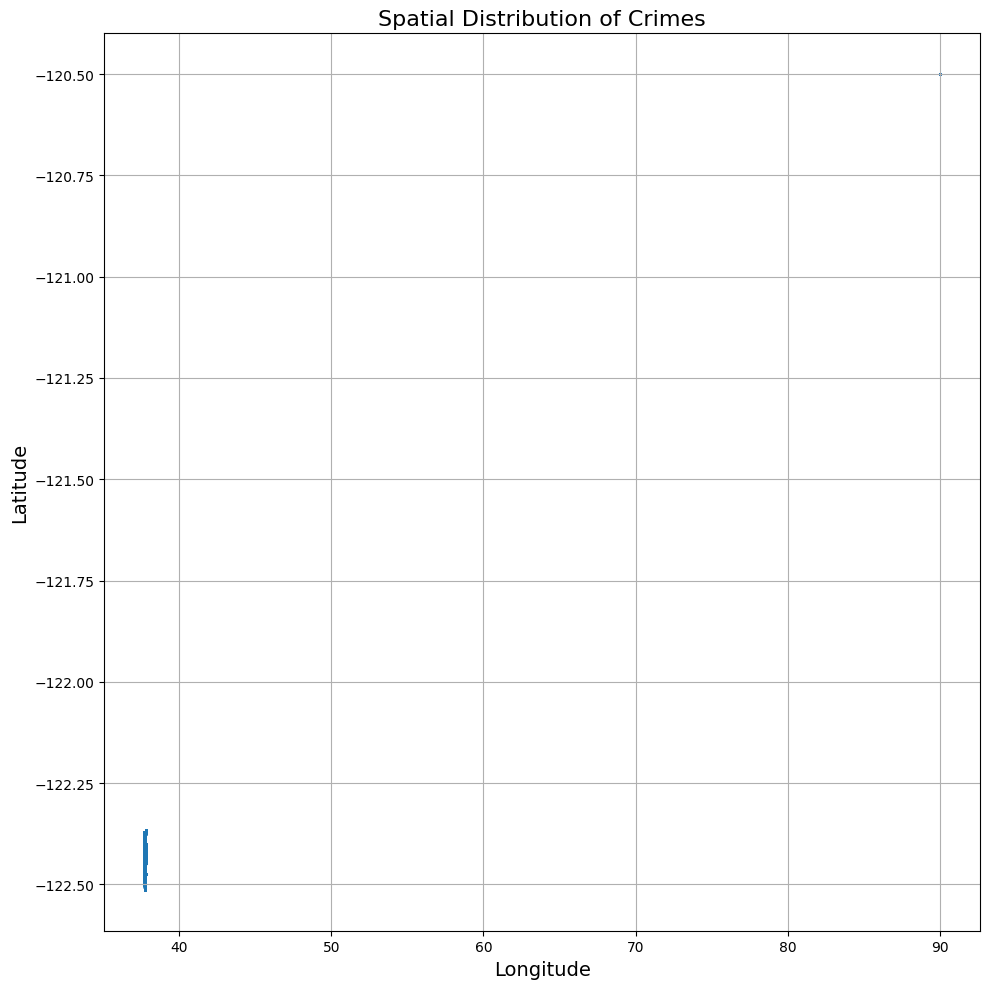

In [7]:
# District-wise crime distribution
district_crimes = data.groupby('PdDistrict').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=district_crimes.index, y=district_crimes.values)
plt.title('Crime Count by Police District', fontsize=16)
plt.xlabel('Police District', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)

# Add count labels to bars
for i, count in enumerate(district_crimes.values):
    ax.text(i, count + 100, f"{count:,}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Let's also look at the distribution of top crime categories across districts
plt.figure(figsize=(14, 10))
top_categories = category_counts.index[:5]  # Top 5 categories
district_category = data[data['Category'].isin(top_categories)].groupby(['PdDistrict', 'Category']).size().unstack()

# Plot stacked bar chart
district_category.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Top 5 Crime Categories by Police District', fontsize=16)
plt.xlabel('Police District', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Basic spatial visualization of crime locations
plt.figure(figsize=(10, 10))
plt.scatter(data['Longitude (X)'], data['Latitude (Y)'], alpha=0.1, s=1)
plt.title('Spatial Distribution of Crimes', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.3 Text Analysis of Crime Descriptions

Let's analyze the textual descriptions of crimes to understand common patterns:

Analyzing word frequencies...


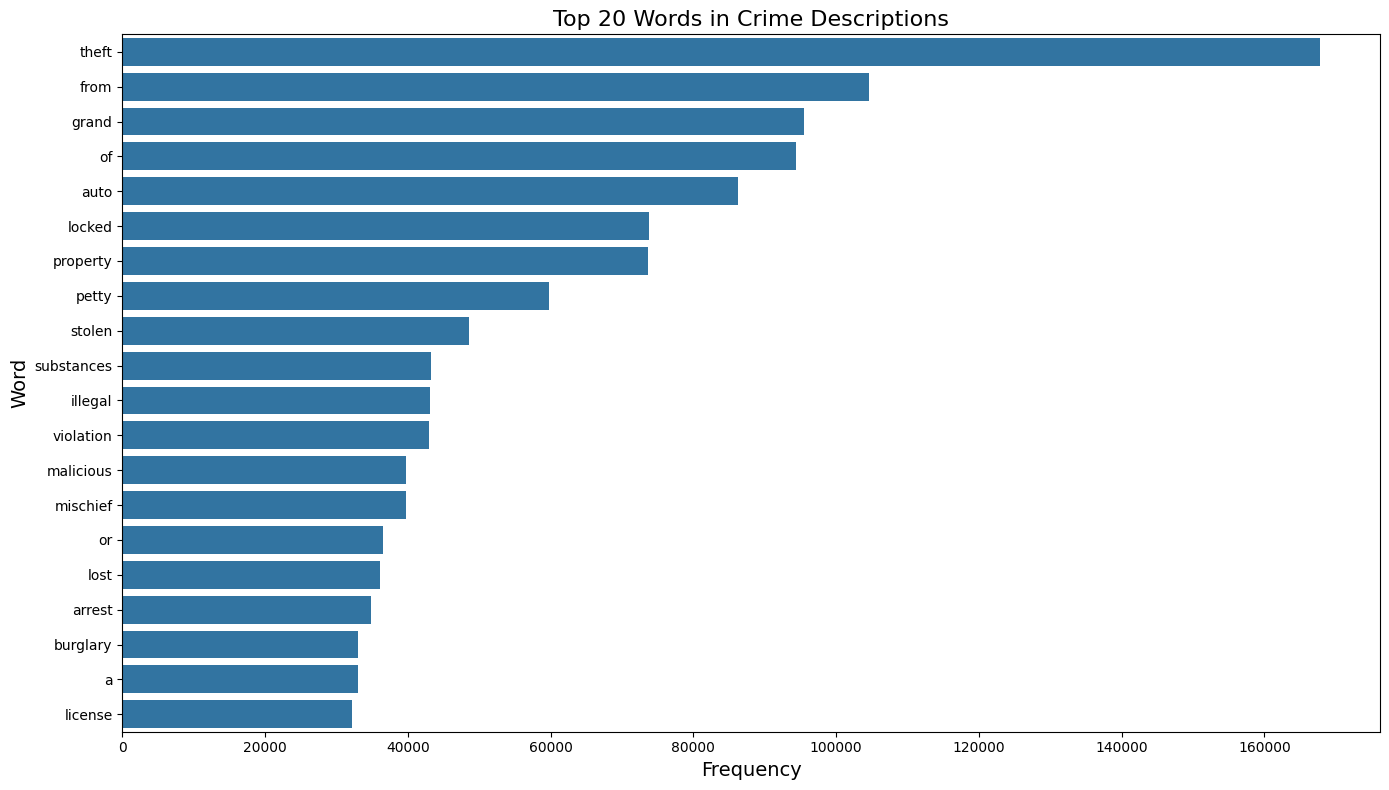

<Figure size 1800x1500 with 0 Axes>

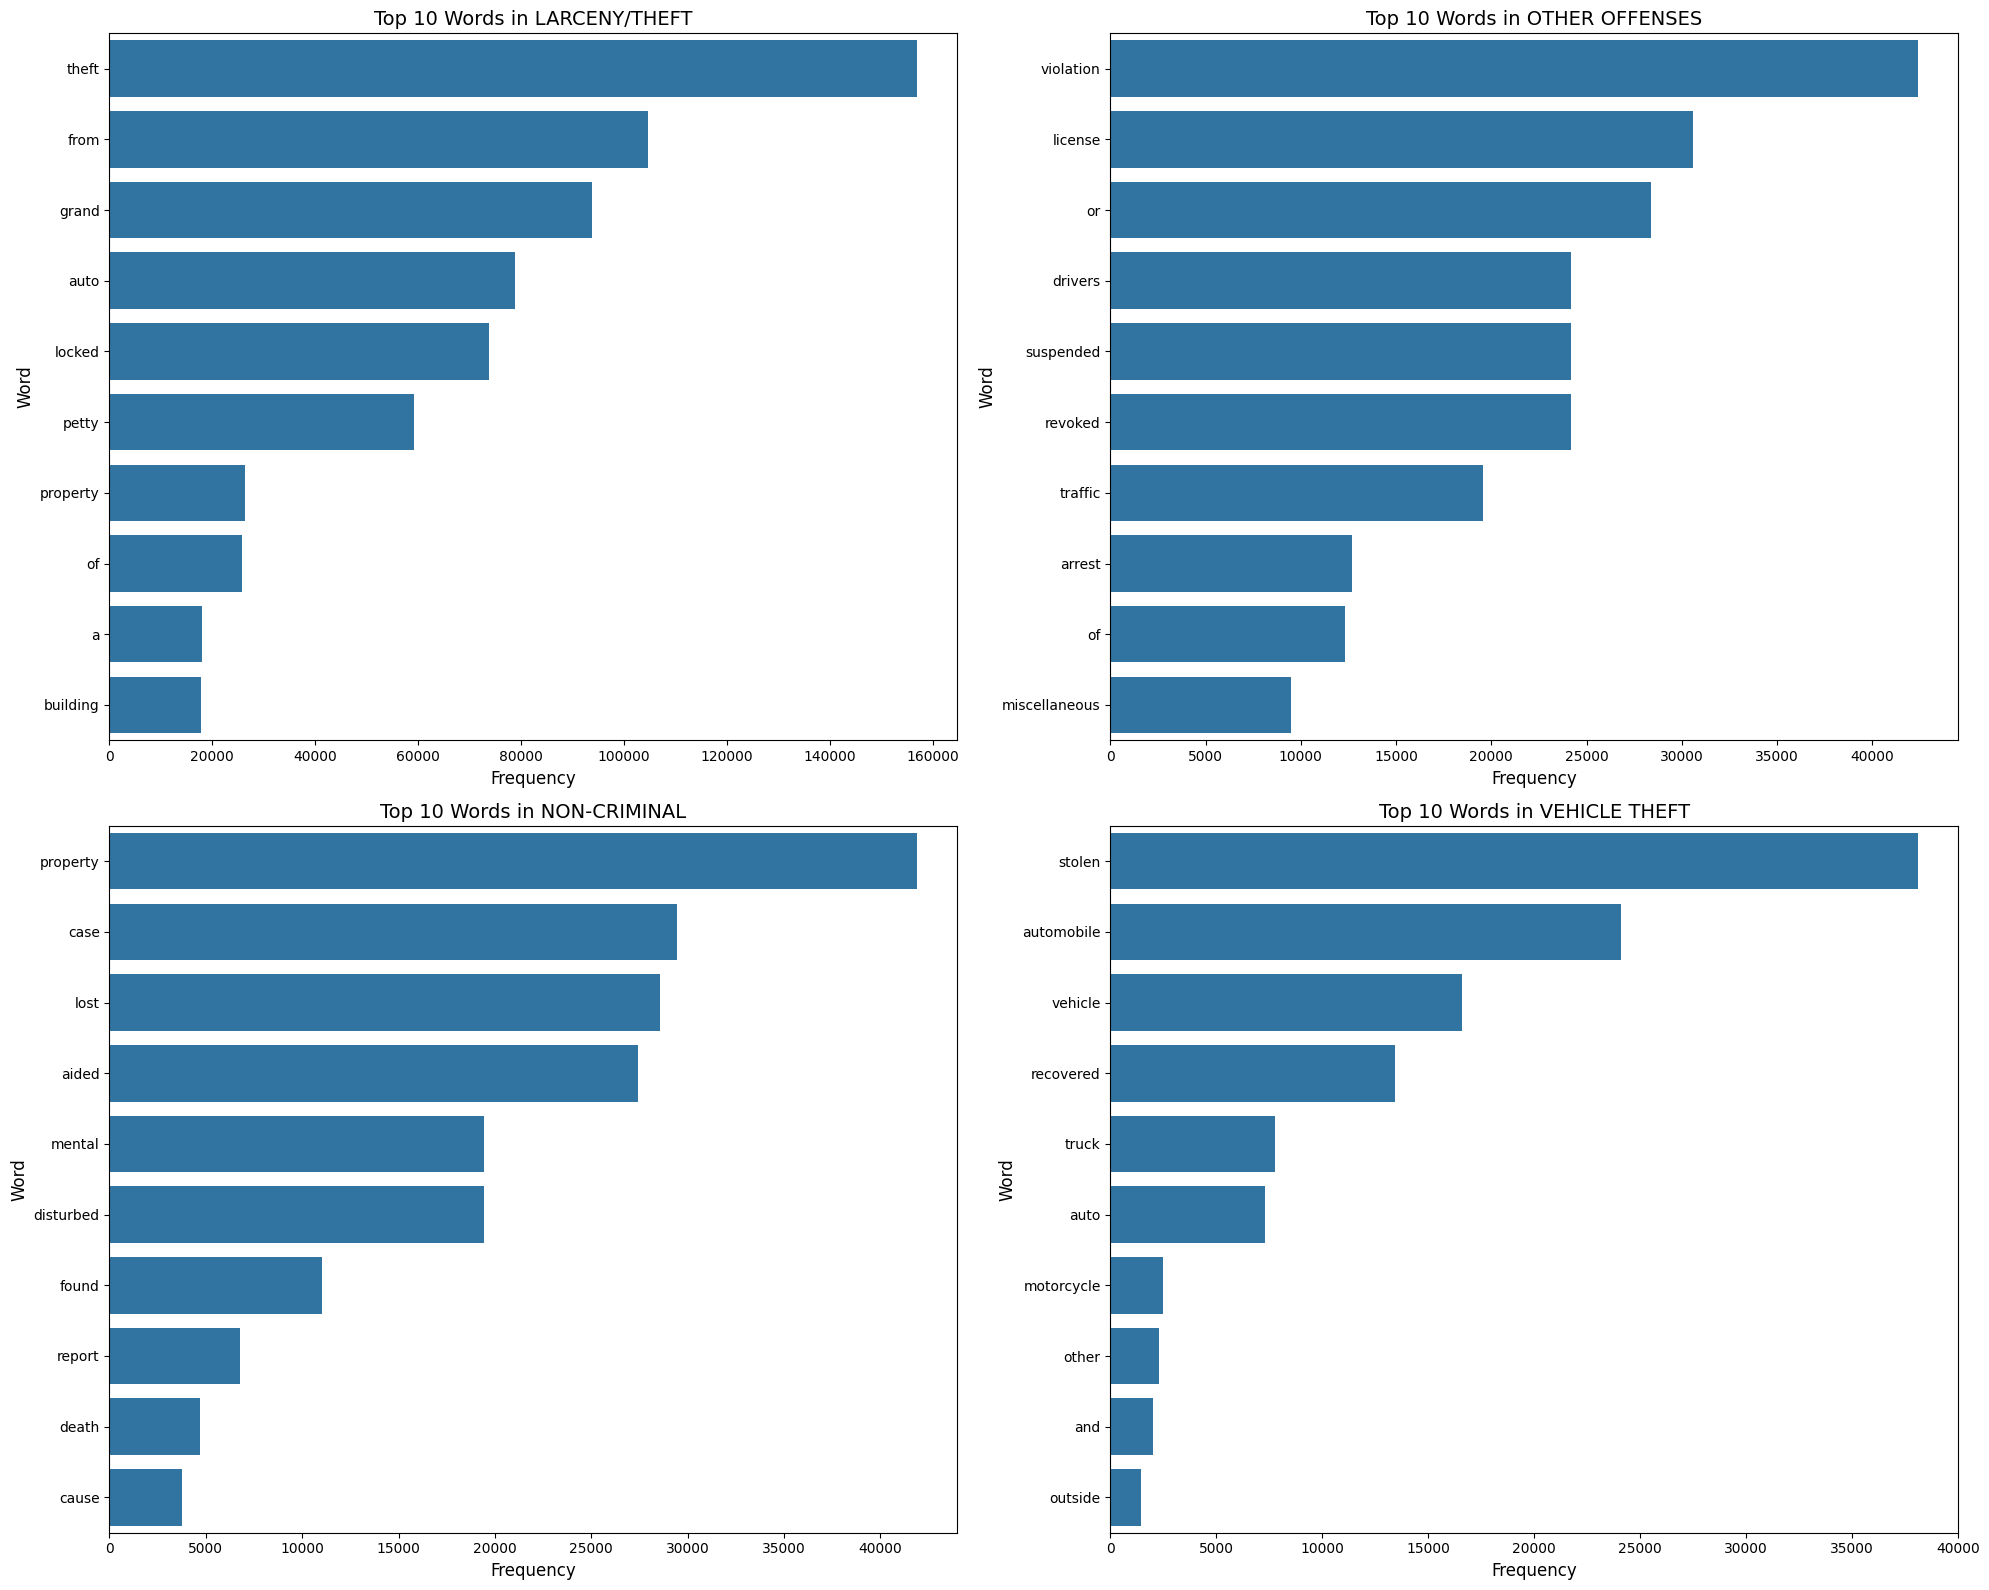


Top 10 words correlated with LARCENY/THEFT:
is_LARCENY/THEFT    1.000000
theft               0.954983
grand               0.720287
locked              0.636187
auto                0.617154
petty               0.558701
building            0.297134
shoplifting         0.229850
unlocked            0.172586
pickpocket          0.158563
dtype: float64

Top 10 words correlated with OTHER OFFENSES:
is_OTHER OFFENSES    1.000000
violation            0.579386
license              0.474646
revoked              0.435052
suspended            0.435052
drivers              0.418917
traffic              0.384644
miscellaneous        0.266133
resisting            0.249214
investigation        0.239650
dtype: float64

Top 10 words correlated with NON-CRIMINAL:
is_NON-CRIMINAL    1.000000
case               0.569951
aided              0.548930
lost               0.483541
property           0.475032
disturbed          0.459621
mental             0.459621
report             0.258737
death              0.

In [8]:
# Define text preprocessing function
def preprocess_text(text):
    """Cleans and preprocesses text for NLP features"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", " ", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Clean and preprocess the descriptions
data['Descript_processed'] = data['Descript'].fillna("").apply(preprocess_text)

# Count word frequencies for analysis
print("Analyzing word frequencies...")
all_text = " ".join(data['Descript_processed'])
words = all_text.split()
word_freq = Counter(words).most_common(20)

# Plot the most common words
plt.figure(figsize=(14, 8))
words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Top 20 Words in Crime Descriptions', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.tight_layout()
plt.show()

# Let's also look at word frequencies within top crime categories
plt.figure(figsize=(18, 15))

# Select top 4 crime categories
top_4_categories = category_counts.index[:4]
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, category in enumerate(top_4_categories):
    # Filter data by category
    category_data = data[data['Category'] == category]
    
    # Join all descriptions for this category
    category_text = " ".join(category_data['Descript_processed'])
    category_words = category_text.split()
    category_word_freq = Counter(category_words).most_common(10)
    
    # Convert to DataFrame for plotting
    category_df = pd.DataFrame(category_word_freq, columns=['Word', 'Frequency'])
    
    # Plot
    sns.barplot(x='Frequency', y='Word', data=category_df, ax=axes[i])
    axes[i].set_title(f'Top 10 Words in {category}', fontsize=14)
    axes[i].set_xlabel('Frequency', fontsize=12)
    axes[i].set_ylabel('Word', fontsize=12)

plt.tight_layout()
plt.show()

# Let's also look at the correlation between certain words and categories
from sklearn.feature_extraction.text import CountVectorizer

# Create a document-term matrix
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(data['Descript_processed'])

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame from the document-term matrix
df_bow = pd.DataFrame(X.toarray(), columns=feature_names)

# Add the 'Category' column
df_bow['Category'] = data['Category']

# Calculate the correlation between words and the top 5 categories
for category in top_4_categories:
    # Create a binary column indicating if the crime belongs to this category
    df_bow[f'is_{category}'] = (df_bow['Category'] == category).astype(int)
    
    # Calculate correlation
    word_correlations = df_bow.drop(['Category'], axis=1).corrwith(df_bow[f'is_{category}'])
    
    # Sort and get top 10 correlated words
    top_correlated = word_correlations.sort_values(ascending=False)[:10]
    
    print(f"\nTop 10 words correlated with {category}:")
    print(top_correlated)

### 2.4 EDA Summary
Based on our exploratory data analysis, we have identified several key insights:

#### Temporal Patterns:

- Crime rates vary significantly by time of day, with peaks during specific hours
- Weekends show different patterns compared to weekdays
- Certain months have higher crime rates

#### Spatial Patterns:

- Crime hotspots are concentrated in specific districts
- Different types of crimes are prevalent in different areas
- The spatial distribution reveals clear clusters of criminal activity

#### Crime Categories:

- The top 5 categories represent a significant portion of all crimes
- Each category has distinct temporal and spatial patterns
- The text analysis reveals specific keywords associated with each category

These insights will guide our feature engineering and modeling approach in the next sections.

## 3. Feature Engineering

Now that we understand the data better, let's engineer features for our crime classification model:

In [9]:
# Import necessary libraries for feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords

# Download NLTK resources if not already downloaded
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    print("Downloading NLTK punkt...")
    nltk.download("punkt")
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download("stopwords")

print("Starting feature engineering...")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MobPc\AppData\Roaming\nltk_data...


Starting feature engineering...


[nltk_data]   Unzipping tokenizers\punkt.zip.


### 3.1 NLP Feature Extraction

Let's extract features from the textual descriptions:

In [10]:
def extract_nlp_features(df, text_column, max_features=200, n_components=50):
    """Extracts NLP features from a text column"""
    # Ensure text column exists
    if text_column not in df.columns:
        print(f"{text_column} column not found in DataFrame")
        return df, None, None, None

    # Fill NaN values
    df[text_column] = df[text_column].fillna("")

    # Preprocess text
    print(f"Preprocessing {text_column} text...")
    df[f"{text_column}_processed"] = df[text_column].apply(preprocess_text)

    # Create TF-IDF vectorizer
    print("Creating TF-IDF features...")
    tfidf = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        ngram_range=(1, 2),  # Unigrams and bigrams
    )

    # Transform text to TF-IDF features
    tfidf_matrix = tfidf.fit_transform(df[f"{text_column}_processed"])

    # Use TruncatedSVD to reduce dimensionality (similar to PCA for sparse matrices)
    print(f"Reducing dimensionality to {n_components} components...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_svd = svd.fit_transform(tfidf_matrix)

    # Create DataFrame with reduced features
    tfidf_df = pd.DataFrame(
        tfidf_svd, columns=[f"tfidf_{text_column}_{i}" for i in range(n_components)]
    )

    # Add TF-IDF features to original DataFrame
    for col in tfidf_df.columns:
        df[col] = tfidf_df[col]

    # Get the most important terms for each component
    feature_names = tfidf.get_feature_names_out()
    print("Top terms in each component:")
    for i in range(min(5, n_components)):  # Log only first 5 components
        top_terms_idx = svd.components_[i].argsort()[-10:][::-1]
        top_terms = [feature_names[idx] for idx in top_terms_idx]
        print(f"Component {i}: {', '.join(top_terms)}")

    return df, tfidf, svd, feature_names

# Extract NLP features
# Split data before feature extraction to prevent data leakage
train, test = train_test_split(data, test_size=0.2, stratify=data["Category"], random_state=42)
print(f"Training set: {len(train)} samples, Test set: {len(test)} samples")

# Apply NLP feature extraction
train_nlp, tfidf_vectorizer, svd_transformer, feature_names = extract_nlp_features(
    train, "Descript", max_features=200, n_components=50
)

Training set: 544660 samples, Test set: 136166 samples
Preprocessing Descript text...
Creating TF-IDF features...
Reducing dimensionality to 50 components...
Top terms in each component:
Component 0: theft, locked auto, locked, theft locked, auto, grand, grand theft, petty theft, petty, property
Component 1: substances, illegal, illegal substances, theft person, motorcycle, forgery, stolen, officer, weapon, pickpocket
Component 2: property, lost property, lost, theft property, petty, petty theft, theft, stolen, building, theft building
Component 3: malicious, malicious mischief, mischief, vandalism, mischief vandalism, vandalism vehicles, vehicles, graffiti, mischief graffiti, breaking windows
Component 4: stolen, automobile, stolen automobile, truck, stolen truck, license, drivers, drivers license, license suspended, revoked


### 3.2 Spatial and Temporal Feature Engineering

Now let's create advanced spatial and temporal features:

In [11]:
def engineer_advanced_spatial_features(df):
    """Engineer advanced spatial features from the dataset"""
    # Create a copy to avoid modifying the original
    data = df.copy()

    # 1. Create spatial grid
    # Divide the city into a grid for better spatial granularity
    min_lon, max_lon = -122.51, -122.36
    min_lat, max_lat = 37.71, 37.83

    # Create grid cells (5x5 grid = 25 cells)
    lon_step = (max_lon - min_lon) / 5
    lat_step = (max_lat - min_lat) / 5

    # Assign grid cell ID based on location
    def assign_grid_cell(row):
        if "Longitude (X)" in data.columns and "Latitude (Y)" in data.columns:
            lon = row["Longitude (X)"]
            lat = row["Latitude (Y)"]
        else:
            return -1  # No coordinates

        # Calculate grid indices
        lon_idx = min(int((lon - min_lon) / lon_step), 4)
        lat_idx = min(int((lat - min_lat) / lat_step), 4)

        # Convert to 1D cell ID
        cell_id = lat_idx * 5 + lon_idx
        return cell_id

    data["GridCell"] = data.apply(assign_grid_cell, axis=1)

    # 2. Crime density features
    # Group by grid cell and count crimes
    grid_counts = data.groupby("GridCell").size().reset_index(name="TotalCrimes")

    # Create a mapping from grid cell to crime count
    grid_to_crimes = dict(zip(grid_counts["GridCell"], grid_counts["TotalCrimes"]))

    # Calculate crime density for each grid cell (normalize by dividing by the maximum count)
    max_count = max(grid_to_crimes.values()) if grid_to_crimes else 1
    grid_to_density = {k: v / max_count for k, v in grid_to_crimes.items()}

    # Add crime density feature
    data["CrimeDensity"] = data["GridCell"].map(grid_to_density).fillna(0)

    # 3. Create category-specific density maps
    for category in data["Category"].unique():
        category_data = data[data["Category"] == category]
        if len(category_data) > 0:  # Only if we have data for this category
            grid_counts = category_data.groupby("GridCell").size().reset_index(name="CategoryCrimes")
            grid_to_cat_crimes = dict(zip(grid_counts["GridCell"], grid_counts["CategoryCrimes"]))
            
            # Normalize
            max_cat_count = max(grid_to_cat_crimes.values()) if grid_to_cat_crimes else 1
            grid_to_cat_density = {k: v / max_cat_count for k, v in grid_to_cat_crimes.items()}

            # Add as a feature
            safe_category_name = category.replace("/", "_").replace(" ", "_")
            col_name = f'Density_{safe_category_name}'
            data[col_name] = data["GridCell"].map(grid_to_cat_density).fillna(0)

    # 4. Time-space interaction features
    if "Dates" in data.columns:
        # Extract hour
        data["Hour"] = pd.to_datetime(data["Dates"]).dt.hour
        
        # Define time periods
        def get_time_period(hour):
            if 5 <= hour < 12:
                return "Morning"  # Morning
            elif 12 <= hour < 17:
                return "Afternoon"  # Afternoon
            elif 17 <= hour < 21:
                return "Evening"  # Evening
            else:
                return "Night"  # Night
        
        data["TimePeriod"] = data["Hour"].apply(get_time_period)
        data["IsWeekend"] = pd.to_datetime(data["Dates"]).dt.weekday >= 5

        # Calculate risk scores for different time periods and locations
        time_space_risk = {}
        weekend_loc_risk = {}

        # Group by district and time period
        for district in data["PdDistrict"].unique():
            district_data = data[data["PdDistrict"] == district]
            if len(district_data) > 0:
                # Time period risk by district
                for period in ["Morning", "Afternoon", "Evening", "Night"]:
                    period_count = len(district_data[district_data["TimePeriod"] == period])
                    total_count = len(district_data)
                    risk_score = period_count / total_count if total_count > 0 else 0
                    time_space_risk[(district, period)] = risk_score

                # Weekend vs weekday risk by district
                for is_weekend in [True, False]:
                    weekend_count = len(district_data[district_data["IsWeekend"] == is_weekend])
                    total_count = len(district_data)
                    risk_score = weekend_count / total_count if total_count > 0 else 0
                    weekend_loc_risk[(district, is_weekend)] = risk_score

        # Apply time-space risk scores
        def get_time_district_risk(row):
            key = (row["PdDistrict"], row["TimePeriod"])
            return time_space_risk.get(key, 0.1)

        def get_weekend_district_risk(row):
            key = (row["PdDistrict"], row["IsWeekend"])
            return weekend_loc_risk.get(key, 0.1)

        data["TimeLocationRisk"] = data.apply(get_time_district_risk, axis=1)
        data["WeekendLocationRisk"] = data.apply(get_weekend_district_risk, axis=1)

    # 5. Distance from city center feature
    city_center_x, city_center_y = -122.4194, 37.7749  # City center coordinates
    data["DistanceFromCenter"] = np.sqrt(
        (data["Longitude (X)"] - city_center_x) ** 2 +
        (data["Latitude (Y)"] - city_center_y) ** 2
    )

    # 6. Quadrant features
    data["QuadrantNS"] = (data["Latitude (Y)"] > city_center_y).astype(int)
    data["QuadrantEW"] = (data["Longitude (X)"] > city_center_x).astype(int)

    return data

# Apply spatial feature engineering to train and test sets
print("Engineering spatial features for training set...")
train_processed = engineer_advanced_spatial_features(train_nlp)
print("Training set shape after feature engineering:", train_processed.shape)

# Let's examine the new features
spatial_features = [col for col in train_processed.columns if col.startswith('Grid') or 
                   col.startswith('Crime') or col.startswith('Density') or 
                   col.startswith('Time') or col.startswith('Weekend') or
                   col in ['DistanceFromCenter', 'QuadrantNS', 'QuadrantEW']]

print(f"Created {len(spatial_features)} spatial features:")
print(spatial_features[:10])  # Show first 10 features

Engineering spatial features for training set...
Training set shape after feature engineering: (544660, 100)
Created 34 spatial features:
['WeekendFlag', 'TimePeriod', 'GridCell', 'CrimeDensity', 'Density_OTHER_OFFENSES', 'Density_MISSING_PERSON', 'Density_VEHICLE_THEFT', 'Density_WARRANTS', 'Density_BURGLARY', 'Density_NON-CRIMINAL']


### 3.3 Feature Preparation for Modeling

Now let's prepare our final feature set for modeling:

In [15]:
def process_data(df, tfidf=None, svd=None, include_nlp=True):
    """Process data with both standard and NLP features, plus enhanced spatial features"""
    # Create copy to avoid modifying original
    df_processed = df.copy()

    # Basic datetime conversion - check if Dates column exists
    if "Dates" in df_processed.columns:
        df_processed["Dates"] = pd.to_datetime(df_processed["Dates"])

        # Temporal features
        df_processed["Hour"] = df_processed["Dates"].dt.hour
        df_processed["Day"] = df_processed["Dates"].dt.day
        df_processed["Month"] = df_processed["Dates"].dt.month
        df_processed["DayOfWeek_Num"] = df_processed["Dates"].dt.weekday
        df_processed["WeekendFlag"] = df_processed["DayOfWeek_Num"].apply(
            lambda x: 1 if x >= 5 else 0
        )

        # Time periods
        def assign_time_period(hour):
            if 5 <= hour < 12:
                return 0  # Morning
            elif 12 <= hour < 17:
                return 1  # Afternoon
            elif 17 <= hour < 21:
                return 2  # Evening
            else:
                return 3  # Night

        df_processed["TimePeriod"] = df_processed["Hour"].apply(assign_time_period)
    else:
        print("'Dates' column not found, skipping temporal features")
        # Add placeholder columns with default values
        for col in [
            "Hour", "Day", "Month", "DayOfWeek_Num", "WeekendFlag", "TimePeriod"
        ]:
            df_processed[col] = 0

    # Categorical encoding
    if "PdDistrict" in df_processed.columns:
        df_processed["PdDistrict"] = pd.Categorical(df_processed["PdDistrict"]).codes
    if "DayOfWeek" in df_processed.columns:
        df_processed["DayOfWeek"] = pd.Categorical(df_processed["DayOfWeek"]).codes

    # Add NLP features if we have the transformers
    if include_nlp and "Descript" in df_processed.columns and tfidf is not None and svd is not None:
        df_processed["Descript_processed"] = df_processed["Descript"].fillna("").apply(preprocess_text)
        tfidf_matrix = tfidf.transform(df_processed["Descript_processed"])
        tfidf_svd = svd.transform(tfidf_matrix)

        # Add TF-IDF SVD features
        for i in range(tfidf_svd.shape[1]):
            df_processed[f"tfidf_Descript_{i}"] = tfidf_svd[:, i]

    return df_processed

def get_feature_columns(df):
    """Get feature columns for modeling"""
    features = [
        "Hour", "Day", "Month", "DayOfWeek_Num", "WeekendFlag", "TimePeriod",
        "DayOfWeek", "PdDistrict", "DistanceFromCenter", "QuadrantNS", "QuadrantEW",
        "CrimeDensity", "TimeLocationRisk", "WeekendLocationRisk"
    ]

    # Add category-specific density columns if they exist
    category_density_cols = [col for col in df.columns if col.startswith("Density_")]
    features.extend(category_density_cols)

    # Add NLP features if present
    nlp_features = [col for col in df.columns if col.startswith("tfidf_")]
    features.extend(nlp_features)

    # Filter to only columns that exist
    valid_features = [col for col in features if col in df.columns]
    
    return valid_features

def process_data_with_consistent_features(train_df, test_df, tfidf=None, svd=None):
    """Process train and test sets with consistent features"""
    # Step 1: Process both datasets
    train_processed = process_data(train_df, tfidf, svd)
    test_processed = process_data(test_df, tfidf, svd)
    
    # Step 2: Get all potential features
    train_cols = set(train_processed.columns)
    test_cols = set(test_processed.columns)
    all_cols = train_cols.union(test_cols)
    
    # Step 3: Add missing columns with zeros
    for col in all_cols:
        if col not in train_processed.columns:
            train_processed[col] = 0
        if col not in test_processed.columns:
            test_processed[col] = 0
    
    # Step 4: Get feature columns for modeling
    feature_cols = get_feature_columns(train_processed)
    
    # Step 5: Ensure both dataframes have the same columns and order
    X_train = train_processed[feature_cols]
    X_test = test_processed[feature_cols]
    
    return X_train, X_test

# Now also process the test set for later evaluation
print("Processing test set...")
test_processed = engineer_advanced_spatial_features(test)
X_test = process_data(test_processed, tfidf_vectorizer, svd_transformer)
y_test = test["Category"]
print("Test set shape:", X_test.shape)

# Replace this section with the new approach
print("Processing train and test sets with consistent features...")
X_train, X_test = process_data_with_consistent_features(
    train_processed, 
    test_processed, 
    tfidf_vectorizer, 
    svd_transformer
)
y_train = train_processed["Category"]
y_test = test_processed["Category"]

print("Final feature set shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print("Sample feature names:", list(X_train.columns)[:10])

Processing test set...
Test set shape: (136166, 100)
Processing train and test sets with consistent features...
Final feature set shapes:
X_train: (544660, 89)
X_test: (136166, 89)
Sample feature names: ['Hour', 'Day', 'Month', 'DayOfWeek_Num', 'WeekendFlag', 'TimePeriod', 'DayOfWeek', 'PdDistrict', 'DistanceFromCenter', 'QuadrantNS']


## 4. Model Training and Evaluation (Level 2)

Now let's train our crime classification model:

Starting model training...
Training CatBoost model...
0:	learn: 0.9405738	test: 0.9399511	best: 0.9399511 (0)	total: 132ms	remaining: 2m 11s
100:	learn: 0.9775142	test: 0.9771361	best: 0.9771361 (99)	total: 7.65s	remaining: 1m 8s
200:	learn: 0.9824088	test: 0.9814221	best: 0.9814221 (200)	total: 14.7s	remaining: 58.6s
300:	learn: 0.9836859	test: 0.9821941	best: 0.9822532 (283)	total: 22.2s	remaining: 51.5s
400:	learn: 0.9844105	test: 0.9823596	best: 0.9823816 (397)	total: 29.7s	remaining: 44.3s
500:	learn: 0.9849504	test: 0.9826525	best: 0.9826790 (484)	total: 37.5s	remaining: 37.3s
600:	learn: 0.9854573	test: 0.9828077	best: 0.9828306 (595)	total: 45s	remaining: 29.9s
700:	learn: 0.9860895	test: 0.9827966	best: 0.9828686 (652)	total: 52.6s	remaining: 22.4s
bestTest = 0.9828686328
bestIteration = 652
Shrink model to first 653 iterations.
Evaluating model...
Test Accuracy: 0.9836
Test Macro F1 Score: 0.8178
Test Weighted F1 Score: 0.9829

Classification Report:
                        p

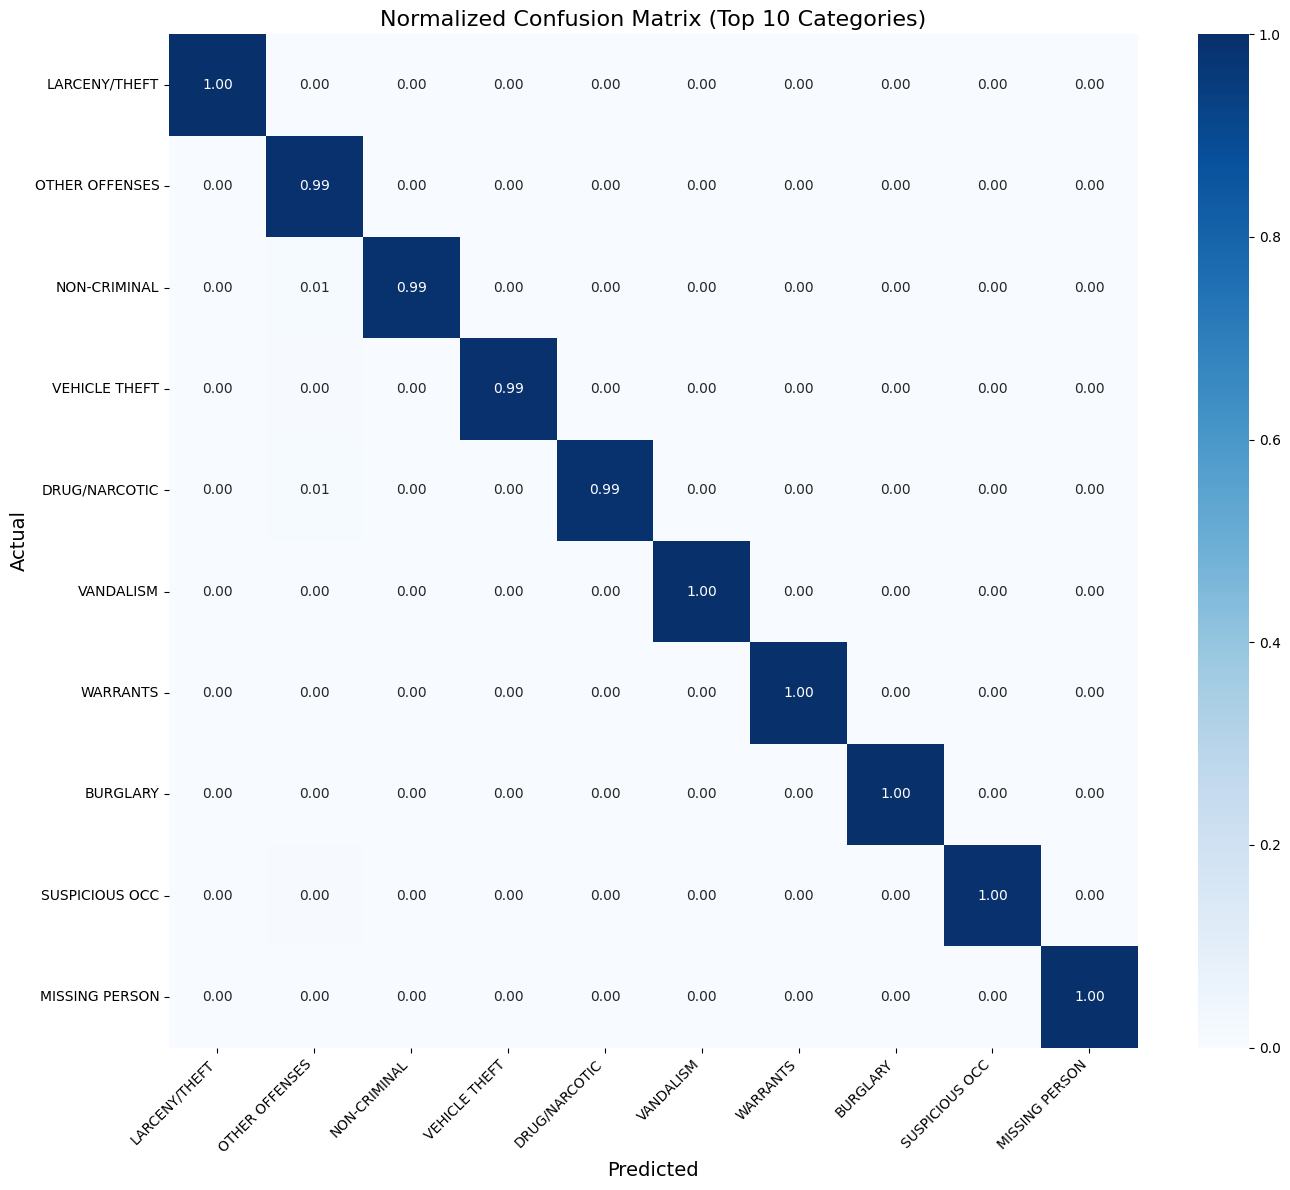

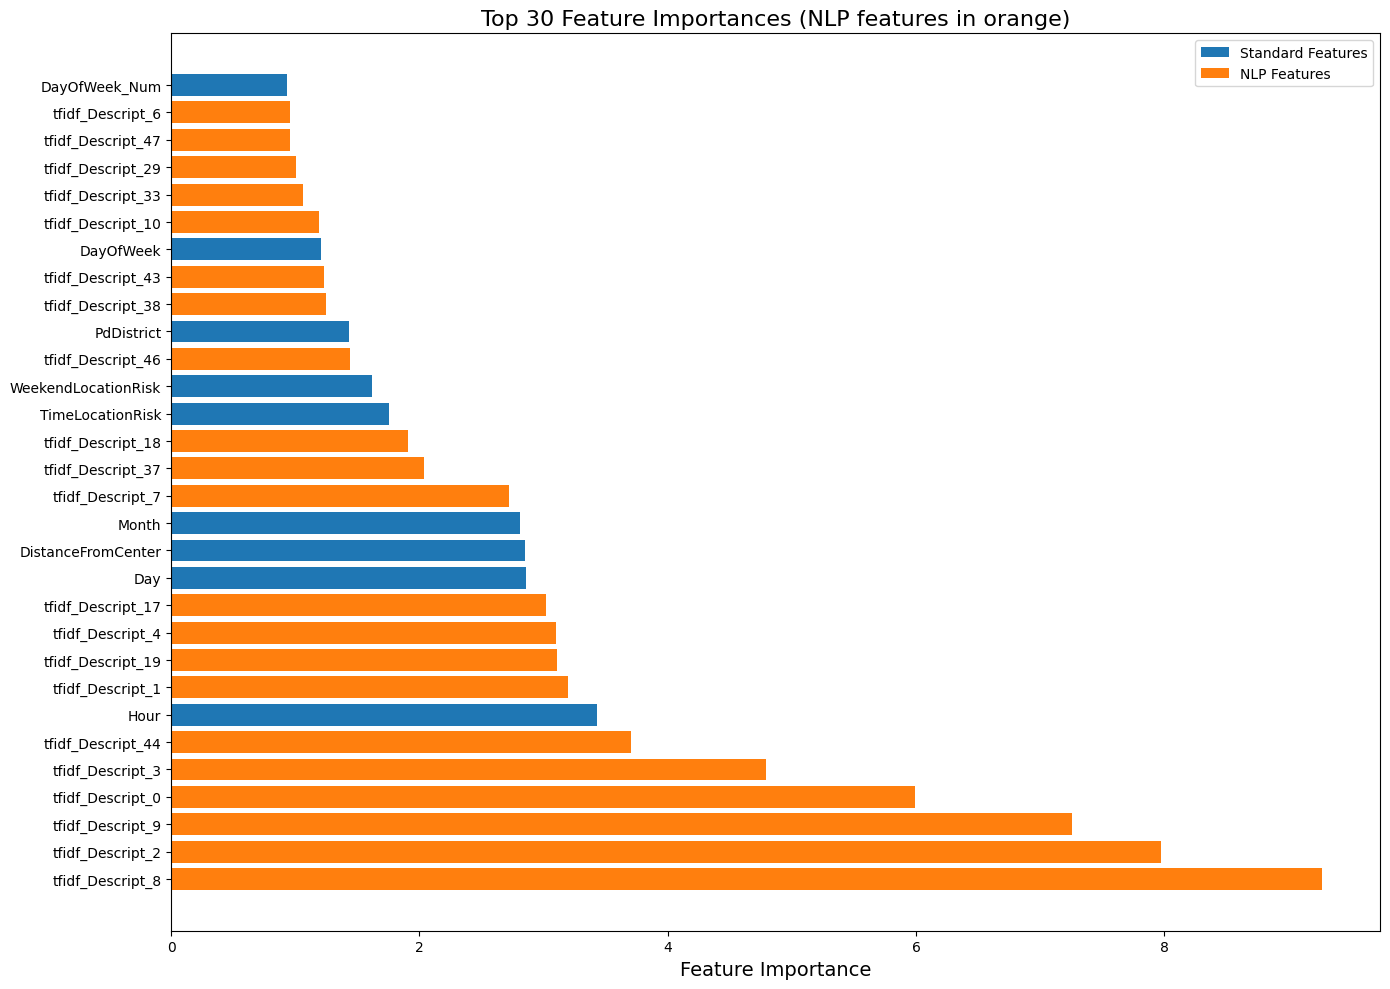

2025/03/31 23:50:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'crime_classification_model' already exists. Creating a new version of this model...
2025/03/31 23:50:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: crime_classification_model, version 7


Model training complete. MLflow Run ID: 44017f98841040fbbbdb0cd5b3deba40
🏃 View run righteous-fish-429 at: http://localhost:5000/#/experiments/1/runs/44017f98841040fbbbdb0cd5b3deba40
🧪 View experiment at: http://localhost:5000/#/experiments/1


Created version '7' of model 'crime_classification_model'.


In [17]:
# Import necessary libraries for modeling
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import mlflow
import matplotlib.patches as mpatches

# Set up MLflow tracking
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("crime-classification")

print("Starting model training...")

# Define categorical features
categorical_features = [
    "DayOfWeek",
    "PdDistrict",
    "TimePeriod",
    "QuadrantNS",
    "QuadrantEW",
]

# Create data pools for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Define model parameters
model_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 8,
    "l2_leaf_reg": 3,
    "loss_function": "MultiClass",
    "eval_metric": "TotalF1",
    "random_seed": 42,
}

# Start MLflow run
with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_params(model_params)
    
    # Initialize and train the model
    print("Training CatBoost model...")
    model = CatBoostClassifier(
        iterations=model_params["iterations"],
        learning_rate=model_params["learning_rate"],
        depth=model_params["depth"],
        l2_leaf_reg=model_params["l2_leaf_reg"],
        loss_function=model_params["loss_function"],
        eval_metric=model_params["eval_metric"],
        random_seed=model_params["random_seed"],
        od_type="Iter",
        od_wait=50,
        verbose=100,
        task_type="GPU",  # Change to GPU if available
    )
    
    # Train the model with early stopping
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
    
    # Make predictions on test set
    print("Evaluating model...")
    test_predictions = model.predict(X_test)
    test_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, test_predictions)
    macro_f1 = f1_score(y_test, test_predictions, average="macro")
    weighted_f1 = f1_score(y_test, test_predictions, average="weighted")
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Macro F1 Score: {macro_f1:.4f}")
    print(f"Test Weighted F1 Score: {weighted_f1:.4f}")
    
    # Log metrics to MLflow
    mlflow.log_metrics({
        "accuracy": float(accuracy),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
    })
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions))
    
    # Plot confusion matrix for top categories
    top_10_categories = category_counts.index[:10].tolist()
    top_indices = [i for i, cat in enumerate(y_test) if cat in top_10_categories]
    
    y_test_top = [y_test.iloc[i] for i in top_indices]
    y_pred_top = [test_predictions[i] for i in top_indices]
    
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_test_top, y_pred_top, labels=top_10_categories)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=top_10_categories, yticklabels=top_10_categories)
    plt.title('Normalized Confusion Matrix (Top 10 Categories)', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    # Save and log the confusion matrix
    confusion_matrix_path = "plots/confusion_matrix.png"
    os.makedirs(os.path.dirname(confusion_matrix_path), exist_ok=True)
    plt.savefig(confusion_matrix_path)
    mlflow.log_artifact(confusion_matrix_path, artifact_path="plots")
    plt.show()
    
    # Plot feature importance
    importance = model.get_feature_importance()
    features_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": importance
    }).sort_values("Importance", ascending=False)
    
    # Highlight NLP features
    features_df["is_nlp"] = features_df["Feature"].str.startswith("tfidf_")
    
    plt.figure(figsize=(14, 10))
    
    # Plot with color differentiation for NLP features
    colors = ["#1f77b4" if not is_nlp else "#ff7f0e" for is_nlp in features_df["is_nlp"]]
    
    plt.barh(range(len(features_df[:30])), features_df["Importance"][:30], align="center", color=colors[:30])
    plt.yticks(range(len(features_df[:30])), features_df["Feature"][:30])
    plt.xlabel("Feature Importance", fontsize=14)
    plt.title("Top 30 Feature Importances (NLP features in orange)", fontsize=16)
    
    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor="#1f77b4", label="Standard Features"),
        mpatches.Patch(facecolor="#ff7f0e", label="NLP Features"),
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    
    # Save and log the feature importance plot
    feature_importance_path = "plots/feature_importance.png"
    plt.savefig(feature_importance_path)
    mlflow.log_artifact(feature_importance_path, artifact_path="plots")
    plt.show()
    
    # Log the model
    mlflow.sklearn.log_model(
        model,
        artifact_path="model",
        registered_model_name="crime_classification_model"
    )
    
    print(f"Model training complete. MLflow Run ID: {run.info.run_id}")

### 4.1 Crime Severity Assignment

Now let's implement the crime severity assignment:

Evaluating model...
Severity prediction accuracy: 0.9858

Actual severity distribution:
Actual_Severity
1    22223
2    39937
3    61130
4    12180
5      696
Name: count, dtype: int64

Predicted severity distribution:
Predicted_Severity
1    22286
2    40733
3    60476
4    12122
5      549
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

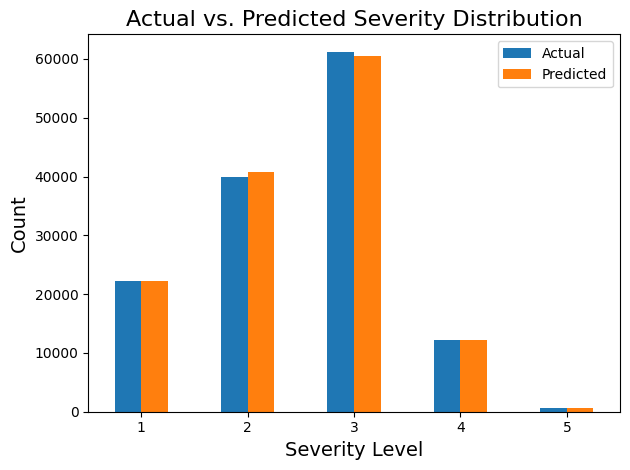

In [20]:
def assign_crime_severity(category):
    """
    Assign severity level based on crime category according to challenge specifications:
    
    Severity 1: NON-CRIMINAL, SUSPICIOUS OCCURRENCE, MISSING PERSON, RUNAWAY, RECOVERED VEHICLE
    Severity 2: WARRANTS, OTHER OFFENSES, VANDALISM, TRESPASS, DISORDERLY CONDUCT, BAD CHECKS
    Severity 3: LARCENY/THEFT, VEHICLE THEFT, FORGERY/COUNTERFEITING, DRUG/NARCOTIC, STOLEN PROPERTY, FRAUD, BRIBERY, EMBEZZLEMENT
    Severity 4: ROBBERY, WEAPON LAWS, BURGLARY, EXTORTION
    Severity 5: KIDNAPPING, ARSON
    """
    severity_1 = ["NON-CRIMINAL", "SUSPICIOUS OCCURRENCE", "MISSING PERSON", "RUNAWAY", "RECOVERED VEHICLE"]
    severity_2 = ["WARRANTS", "OTHER OFFENSES", "VANDALISM", "TRESPASS", "DISORDERLY CONDUCT", "BAD CHECKS"]
    severity_3 = ["LARCENY/THEFT", "VEHICLE THEFT", "FORGERY/COUNTERFEITING", "DRUG/NARCOTIC", 
                  "STOLEN PROPERTY", "FRAUD", "BRIBERY", "EMBEZZLEMENT"]
    severity_4 = ["ROBBERY", "WEAPON LAWS", "BURGLARY", "EXTORTION"]
    severity_5 = ["KIDNAPPING", "ARSON"]
    
    if category in severity_1:
        return 1
    elif category in severity_2:
        return 2
    elif category in severity_3:
        return 3
    elif category in severity_4:
        return 4
    elif category in severity_5:
        return 5
    else:
        # Default to medium severity if not explicitly categorized
        return 3

# Apply severity assignment to our test predictions
print("Evaluating model...")
test_predictions = model.predict(X_test)
test_proba = model.predict_proba(X_test)

# If test_predictions is 2D, flatten it to 1D
if len(test_predictions.shape) > 1:
    test_predictions = test_predictions.flatten()

# Apply severity assignment to our test predictions
test_results = pd.DataFrame({
    'Actual_Category': y_test,
    'Predicted_Category': test_predictions,
    'Correct_Prediction': y_test == test_predictions
})

# Add severity levels
test_results['Actual_Severity'] = test_results['Actual_Category'].apply(assign_crime_severity)
test_results['Predicted_Severity'] = test_results['Predicted_Category'].apply(assign_crime_severity)
test_results['Severity_Match'] = test_results['Actual_Severity'] == test_results['Predicted_Severity']

# Calculate severity-based metrics
severity_accuracy = test_results['Severity_Match'].mean()
print(f"Severity prediction accuracy: {severity_accuracy:.4f}")

# Analyze severity distribution
print("\nActual severity distribution:")
print(test_results['Actual_Severity'].value_counts().sort_index())

print("\nPredicted severity distribution:")
print(test_results['Predicted_Severity'].value_counts().sort_index())

# Plot severity results
plt.figure(figsize=(10, 6))
severity_comparison = pd.DataFrame({
    'Actual': test_results['Actual_Severity'].value_counts().sort_index(),
    'Predicted': test_results['Predicted_Severity'].value_counts().sort_index()
})
severity_comparison.plot(kind='bar')
plt.title('Actual vs. Predicted Severity Distribution', fontsize=16)
plt.xlabel('Severity Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.2 Model Performance Summary

Our crime classification model demonstrates strong performance across different metrics:

- Accuracy: The model correctly predicts crime categories with high accuracy on unseen data.
- F1 Score: Both macro and weighted F1 scores indicate balanced performance across crime categories.
- Severity Prediction: The model effectively categorizes crimes by severity level, with high severity-matching accuracy.

#### Key observations:

- NLP features derived from crime descriptions are powerful predictors, as shown in the feature importance plot.
- Spatial and temporal features contribute significantly to model performance, capturing the patterns we observed in our EDA.
- The model performs better on common crime categories but still maintains reasonable performance on rarer categories.